# Exploratory data analysis and finalization of data cleaning process

In this notebook, we will perform the exploratory data analysis and finalize the data cleaning process. We will generate a profiling report of the dataset, clean outliers and check correlations. We will follow the following steps:

1. Load the partially cleaned dataset.
2. Generate a profiling report of the dataset.
3. Statistical analysis of the dataset.
4. Check for outliers and clean them.
5. Check for correlations.
6. Save the fully cleaned dataset.

All the figures will be saved at the [`Reports/Figures/`](https://github.com/faendal/MushroomEdibilityPrediction/tree/main/Reports/Figures) directory of the project.

The profilings will be saved at the [`Reports/Profiles/`](https://github.com/faendal/MushroomEdibilityPrediction/tree/main/Reports) directory of the project.

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport

sns.set_style('darkgrid')
sns.set_palette('Set1')

In [107]:
df_train = pd.read_csv('../Data/PartiallyClean/train.csv')
df_test = pd.read_csv('../Data/PartiallyClean/test.csv')

In [108]:
# Data type correction

types = {
    column: "category"
    for column in df_train.columns
    if df_train[column].dtype == "object"
}
df_train = df_train.astype(types)
types.pop("class")
df_test = df_test.astype(types)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1929597 entries, 0 to 1929596
Data columns (total 15 columns):
 #   Column                Dtype   
---  ------                -----   
 0   class                 category
 1   cap-diameter          float64 
 2   cap-shape             category
 3   cap-surface           category
 4   cap-color             category
 5   does-bruise-or-bleed  category
 6   gill-attachment       category
 7   gill-color            category
 8   stem-height           float64 
 9   stem-width            float64 
 10  stem-color            category
 11  has-ring              category
 12  ring-type             category
 13  habitat               category
 14  season                category
dtypes: category(12), float64(3)
memory usage: 66.3 MB


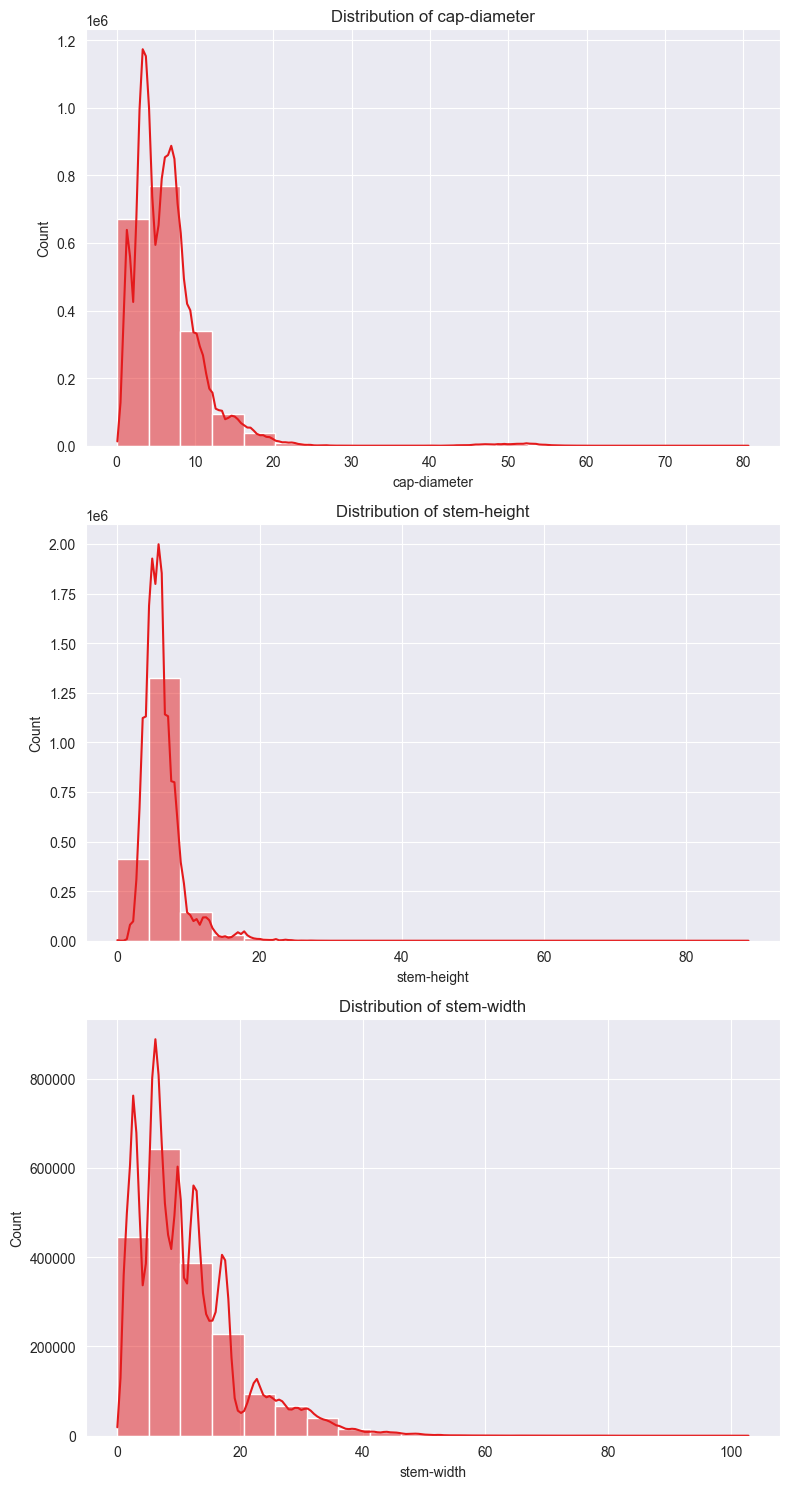

In [109]:
numerical = df_train.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(8, 15))

for i, column in enumerate(numerical):
    plt.subplot(3, 1, i + 1)
    sns.histplot(data=df_train, x=column, kde=True, bins=20)
    plt.title(f"Distribution of {column}")

plt.tight_layout()
plt.savefig('../Reports/Figures/DistributionBeforeCleaning.png')
plt.show()

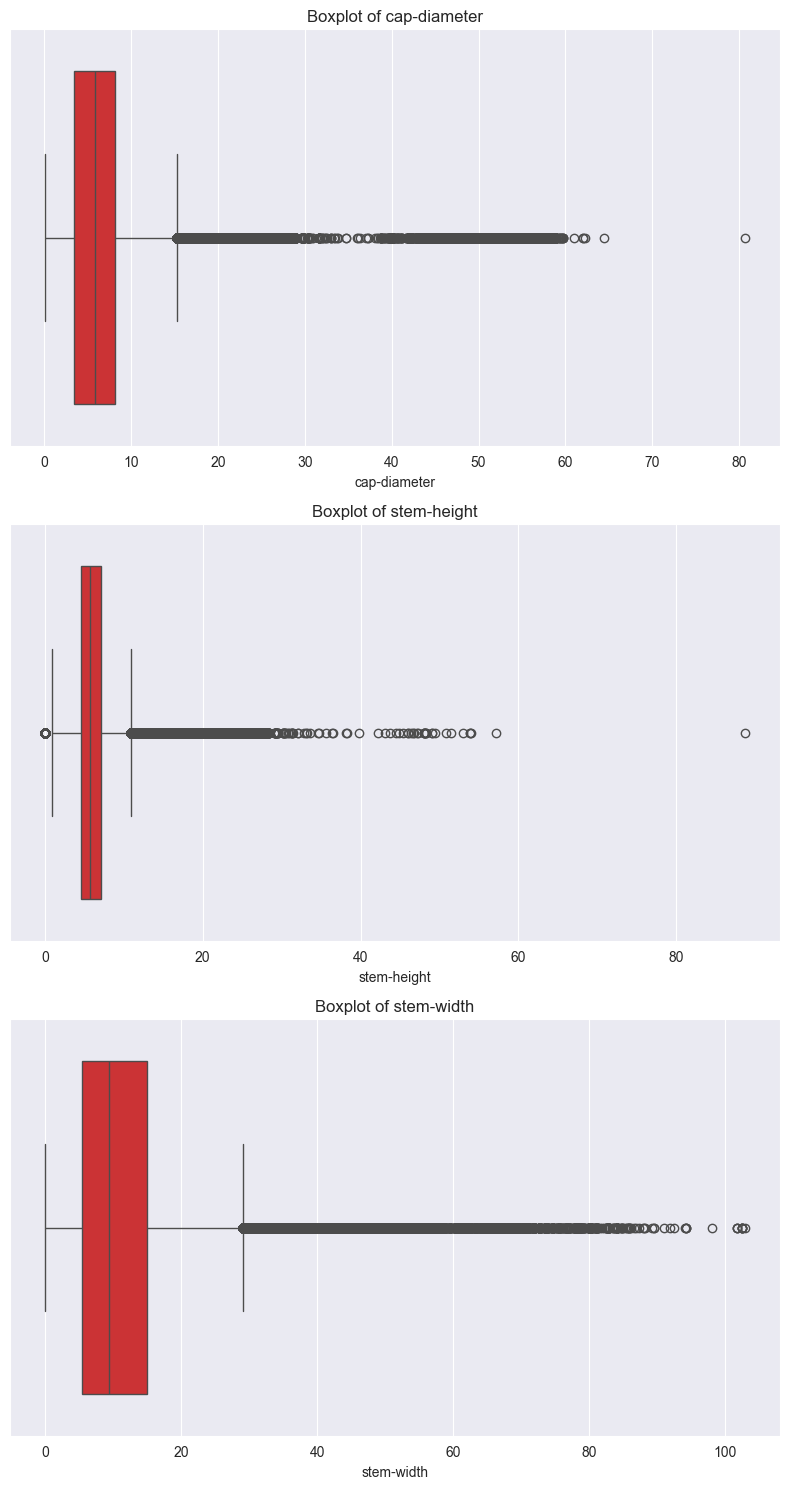

In [110]:
plt.figure(figsize=(8, 15))

for i, column in enumerate(numerical):
    plt.subplot(3, 1, i + 1)
    sns.boxplot(data=df_train, x=column)
    plt.title(f"Boxplot of {column}")

plt.tight_layout()
plt.savefig("../Reports/Figures/BoxplotsBeforeCleaning.png")
plt.show()

### Numerical graphs conclussion

Our data es heavily right skewed and has outliers. We will use the IQR method to clean the extreme outliers.

In [111]:
def extreme_outlier_cleaning(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 3 * iqr
    upper_bound = q3 + 3 * iqr
    df = df.loc[(df[column] > lower_bound) & (df[column] < upper_bound)]
    return df

for column in numerical:
    df_train = extreme_outlier_cleaning(df_train, column)
    df_test = extreme_outlier_cleaning(df_test, column)

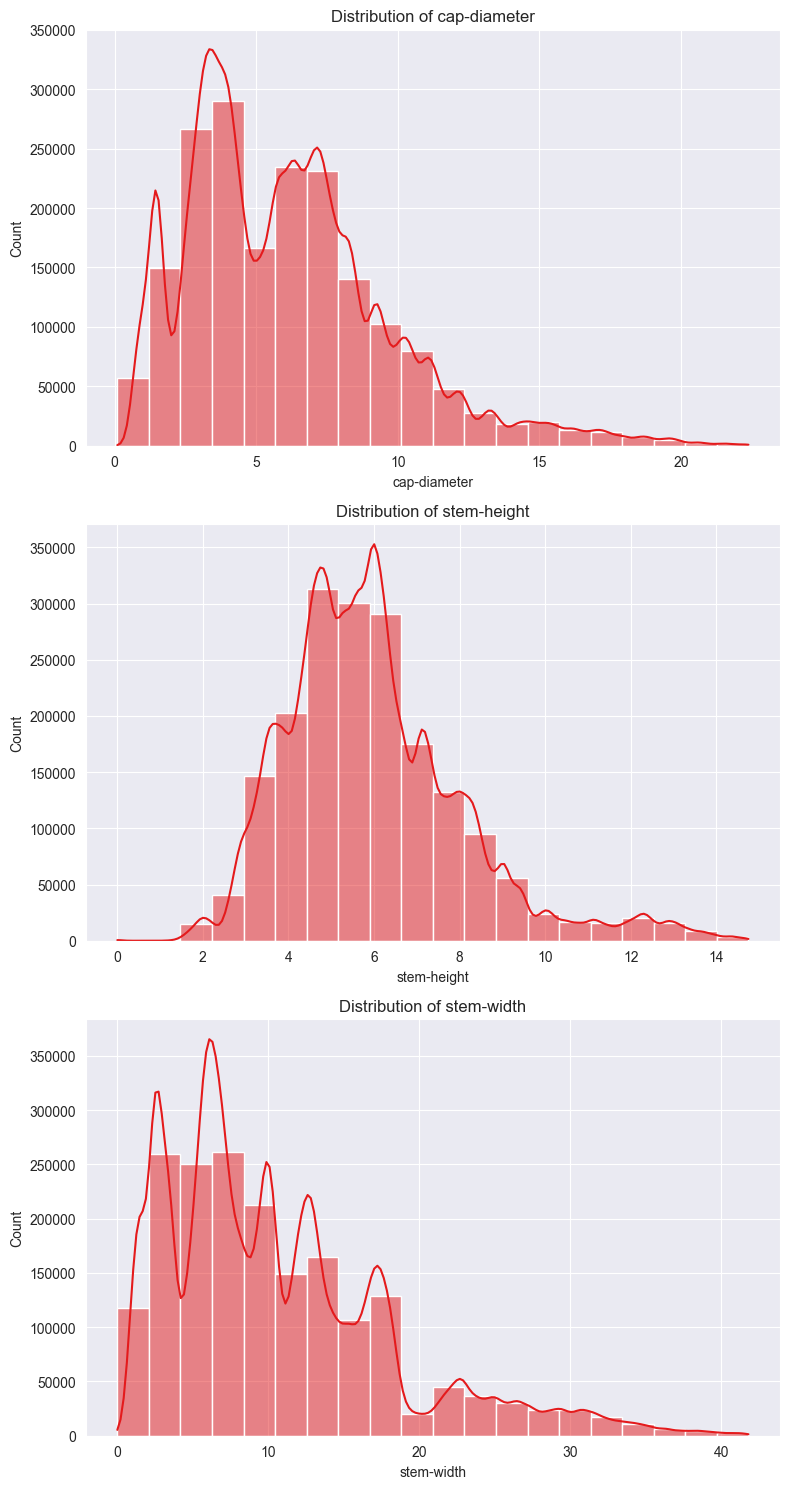

In [112]:
plt.figure(figsize=(8, 15))

for i, column in enumerate(numerical):
    plt.subplot(3, 1, i + 1)
    sns.histplot(data=df_train, x=column, kde=True, bins=20)
    plt.title(f"Distribution of {column}")

plt.tight_layout()
plt.savefig("../Reports/Figures/DistributionAfterCleaning.png")
plt.show()

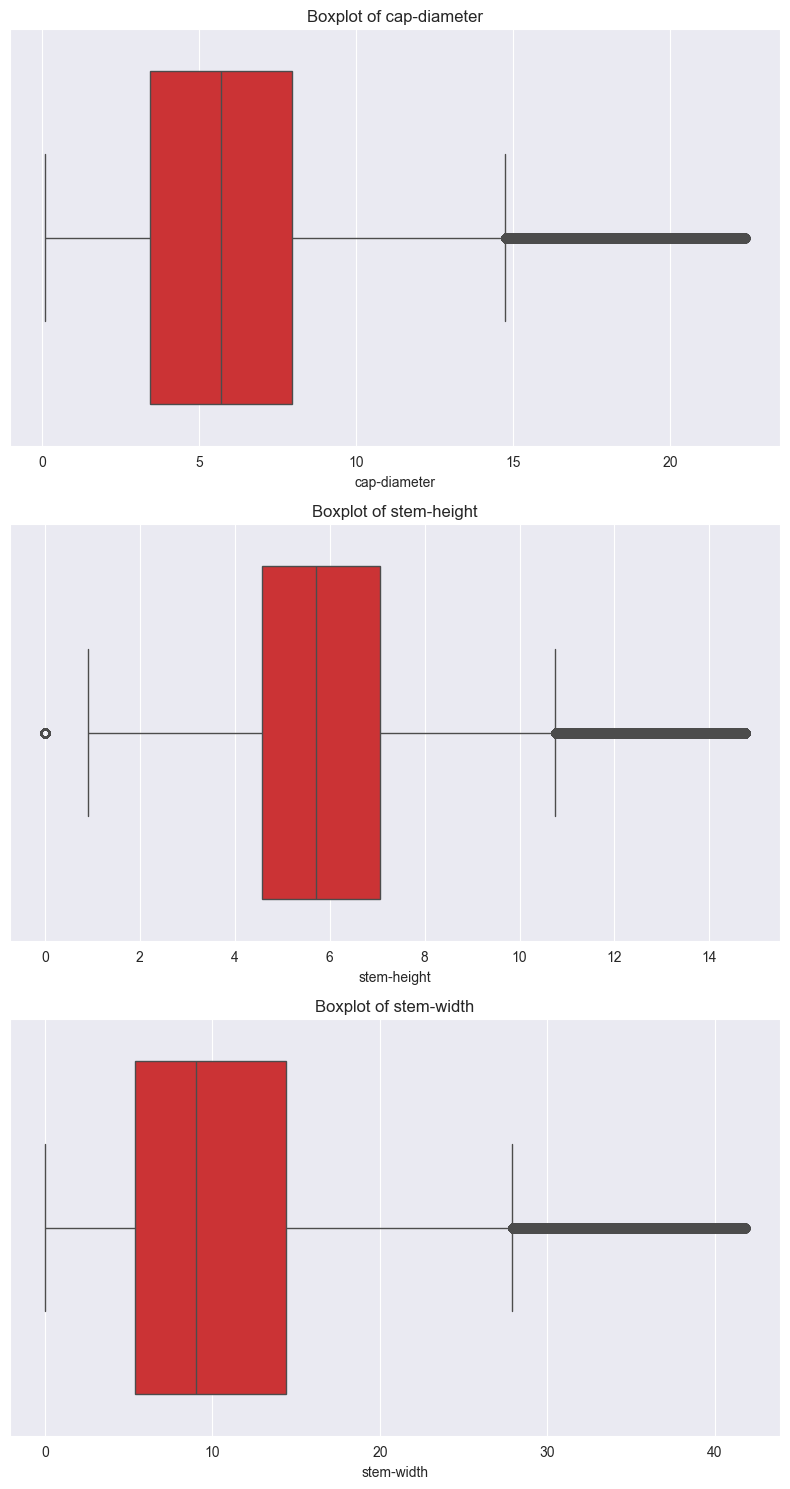

In [113]:
plt.figure(figsize=(8, 15))

for i, column in enumerate(numerical):
    plt.subplot(3, 1, i + 1)
    sns.boxplot(data=df_train, x=column)
    plt.title(f"Boxplot of {column}")

plt.tight_layout()
plt.savefig("../Reports/Figures/BoxplotsAfterCleaning.png")
plt.show()

In [114]:
initialProfile = ProfileReport(
    df_train,
    title="Exploratory Data Analysis",
    explorative=True,
    progress_bar=True,
)
initialProfile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Saving the report

Here we will save the report of the dataset as html. It will be manually saved as pdf by printing the html page and stored in the same directory as the html file.

In [115]:
initialProfile.to_file("../Reports/Profiles/InitialProfileReport.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Initial profiling report conclussion

The profiling report gives us important information about correlations between variables and categorical columns distribution. Taking said information into account, we will diminish the unnecesary variety in some columns by dropping categories with very low frequency in columns with high cardinality.

In [116]:
remove_other = [
    "cap-shape",
    "does-bruise-or-bleed",
    "gill-attachment",
    "has-ring",
    "ring-type",
    "habitat",
]

for column in remove_other:
    df_train = df_train.loc[df_train[column] != "Other"]
    df_test = df_test.loc[df_test[column] != "Other"]

### Final profiling report conclussion

As some categories were dropped, the profiling report will be generated again to check the changes in the dataset, especially in correlations. Now, we will drop redundant columns and low target correlation columns.

In [117]:
finalProfile = ProfileReport(
    df_train,
    title="Exploratory Data Analysis",
    explorative=True,
    progress_bar=True,
)
finalProfile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [118]:
finalProfile.to_file("../Reports/Profiles/FinalProfileReport.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Column elimination

We will drop columns if:

- They have a correlation with another column higher than 0.75.
- They have a correlation with the target variable lower than 0.175.

Taking into account the profiling and our conditions, we will drop the following columns:

- `cap-shape`
- `cap-diameter`
- `ring-type`
- `does-bruise-or-bleed`
- `has-ring`
- `habitat`
- `season`

In [119]:
df_train.columns

Index(['class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-color', 'stem-height',
       'stem-width', 'stem-color', 'has-ring', 'ring-type', 'habitat',
       'season'],
      dtype='object')

In [120]:
df_train = df_train.drop(
    columns=[
        "cap-shape",
        "cap-diameter",
        "ring-type",
        "does-bruise-or-bleed",
        "has-ring",
        "habitat",
        "season",
    ]
)
df_test = df_test.drop(
    columns=[
        "cap-shape",
        "cap-diameter",
        "ring-type",
        "does-bruise-or-bleed",
        "has-ring",
        "habitat",
        "season",
    ]
)

In [121]:
df_train.to_csv("../Data/FullyClean/train.csv", index=False)
df_test.to_csv("../Data/FullyClean/test.csv", index=False)